<a href="https://colab.research.google.com/github/gauthier-schweitzer/Adaboost/blob/master/TAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reproducting the Adaboost Algorithm

Loic Macherel, Gauthier Schweitzer, Cyril Verluise

In [0]:
!pip install tqdm

from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
import numpy as np

%pylab inline
import matplotlib.pyplot as plt

np.random.seed(1)

plt.rcParams["figure.figsize"] = (15, 6)

    100% |████████████████████████████████| 51kB 3.5MB/s 
Populating the interactive namespace from numpy and matplotlib


In [0]:
class AdaBoost_M1:
    """Class implementing the Adaboost M1 algorithm as described in Algo 10.1 of Elements of statistical learning.
       Binary classification"""
    
    def __init__ (self, classifier, **kwargs ):
        """classifier : class of classifier to use e.g DecisionTreeClassifier.
           Must have fit and predict methods as in sklearn.
           keywords arguments are used to determine the parameters of the tree at each iteration."""
        self.classifier = classifier
        self.predictors = []
        self.predictor_weights = []
        self.classifier_kwargs = kwargs
        self.training_history = [] # Store the proportion of labels correctly identified at each iteration
        
        
    def fit(self, X, Y, weights=None, n_iter=100, 
            subsampling=False, shrinkage=1,
            reset=True):
        """X : training features
           Y : training labels
           weights : original weights
           n_iter : number of iterations
           subsampling : if not None, float between 0 and 1 determining the proportion of the training set to use in an iteration,
           shrinking_constant : shrinkage value (learning rate)"""
        if reset:
            self.predictors = []
            self.predictors_weights = []
            self.training_history = []
        if weights is None: # initialize the weigths
            weights = np.ones_like(Y)/len(Y)
            
        X_train = X
        Y_train = Y
        weights_train = weights
        
        for m in tqdm(range(n_iter)):
            classifier = self.classifier(splitter="random", **self.classifier_kwargs)
            
            if subsampling : # Then only one part of the training set is used in this iteration
                size = int(Y.size * subsampling) # Round down to the nearest integer
                subsample_indexes = np.random.choice(np.arange(Y.size), size, replace=False)
                X_train = X[subsample_indexes]
                Y_train = Y[subsample_indexes]
                weights_train = weights[subsample_indexes]
                
            classifier.fit(X_train, Y_train, weights_train)
            pred = classifier.predict(X)
            diff = pred != Y # Labels predicted incorrectly
            err = np.sum(diff * weights)/np.sum(weights)
            alpha = np.log((1 - err) / err )
            weights *= np.exp(diff * alpha)
            
            # Store the weights and predictors
            self.training_history.append(np.mean(diff))
            self.predictors.append(classifier)
            self.predictor_weights.append(alpha * shrinkage)
            
    def predict(self, X):
        """Predict the results from the final classifier."""
        out = np.zeros(X.shape[0])
        for classifier, alpha in zip(self.predictors, self.predictor_weights):
            out += alpha * classifier.predict(X)
        return np.sign(out)
    
    def predict_history(self, X):
        """Yield the prediction for the predictor at each iteration."""
        out = np.zeros(X.shape[0])
        for classifier, alpha in zip(self.predictors, self.predictor_weights):
            out += alpha * classifier.predict(X)
            yield np.sign(out)

In [0]:
# Create the samples
N = 20000 # Number of samples
p = 50  # Number of parameters
true_theta = np.random.normal(size=p)
train_test_prop = 0.8 # Size of the training set relative to the test set
sepidx = np.floor(N*train_test_prop).astype(int) # Index separating training and test set

X_s = np.random.uniform(-1, 1, size=(N, p))
Y_s = np.sign(np.dot(X_s, true_theta)).astype(float)
X_s += np.random.normal(scale=1e-3, size=(N,p)) # Add some noise on the features

In [0]:
predictor_stump = AdaBoost_M1(DecisionTreeClassifier, max_depth=1, max_leaf_nodes=2) # We try with tree stumps
predictor_4deep = AdaBoost_M1(DecisionTreeClassifier, max_depth=4, max_leaf_nodes=32)
predictor_8deep = AdaBoost_M1(DecisionTreeClassifier, max_depth=8, max_leaf_nodes=64)
predictor_deepest = AdaBoost_M1(DecisionTreeClassifier, max_depth=15)

In [0]:
predictor_stump.fit(X_s[:sepidx], Y_s[:sepidx], n_iter=400)
predictor_4deep.fit(X_s[:sepidx], Y_s[:sepidx], n_iter=400)
predictor_8deep.fit(X_s[:sepidx], Y_s[:sepidx], n_iter=400)
predictor_deepest.fit(X_s[:sepidx], Y_s[:sepidx], n_iter=400)

 66%|██████▋   | 265/400 [00:35<00:17,  7.52it/s]

100%|██████████| 400/400 [00:53<00:00,  7.50it/s]


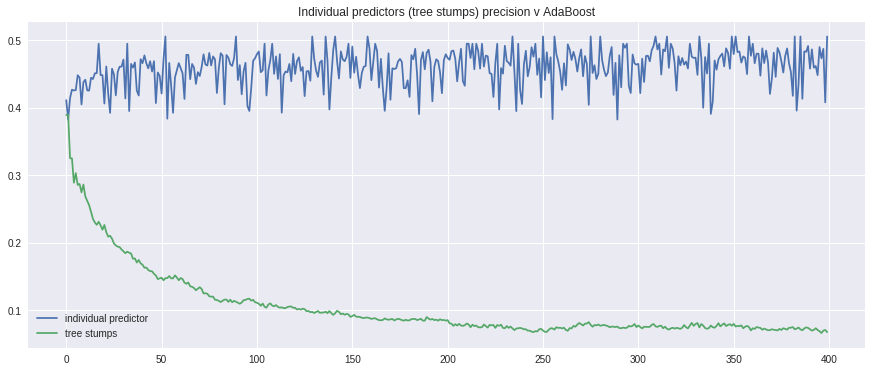

In [0]:
err_stump_M1 = [np.mean(pred != Y_s[sepidx:]) for pred in predictor_stump.predict_history(X_s[sepidx:])]

plt.plot(predictor_stump.training_history, label="individual predictor") # Plot the result of the individual predictors
plt.plot(err_stump_M1, label="tree stumps")
plt.title("Individual predictors (tree stumps) precision v AdaBoost")
plt.legend()
plt.show()

As we see, the individual predictors are very weak (and they are evaluated on the training set)


### Using different depths of trees

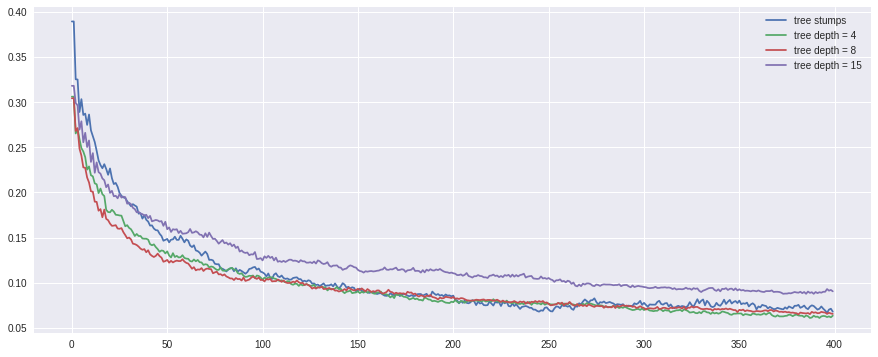

In [0]:
plt.plot(err_stump_M1, label='tree stumps')
plt.plot([np.mean(pred != Y_s[sepidx:]) for pred in predictor_4deep.predict_history(X_s[sepidx:])], label="tree depth = 4")
plt.plot([np.mean(pred != Y_s[sepidx:]) for pred in predictor_8deep.predict_history(X_s[sepidx:])], label="tree depth = 8")
plt.plot([np.mean(pred != Y_s[sepidx:]) for pred in predictor_deepest.predict_history(X_s[sepidx:])], label="tree depth = 15")
plt.legend()
plt.show()

Using deeper trees than stumps seem to give better results (and faster convergence regarding the number of iterations), but at the cost of increased computational cost, and the marginal returns regarding the number of trees seem to be diminishing (trees of depth 8 seem not to perform better than trees of depth 4)

### Shrinkage

It is possible to shrink our AdaBoost algorithm, meaning that only a portion of the prediction of each new tree will be used to prediction.

100%|██████████| 400/400 [00:26<00:00, 15.33it/s]


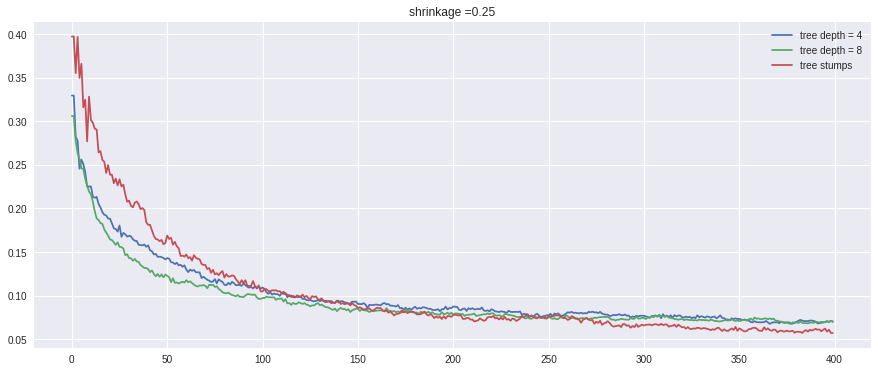

In [0]:
predictor_stump.fit(X_s[:sepidx], Y_s[:sepidx], n_iter=400, shrinkage=0.25)
predictor_4deep.fit(X_s[:sepidx], Y_s[:sepidx], n_iter=400, shrinkage=0.25)
predictor_8deep.fit(X_s[:sepidx], Y_s[:sepidx], n_iter=400, shrinkage=0.25)

plt.plot([np.mean(pred != Y_s[sepidx:]) for pred in predictor_4deep.predict_history(X_s[sepidx:])], 
         label="tree depth = 4")
plt.plot([np.mean(pred != Y_s[sepidx:]) for pred in predictor_8deep.predict_history(X_s[sepidx:])], 
         label="tree depth = 8")
plt.plot([np.mean(pred != Y_s[sepidx:]) for pred in predictor_stump.predict_history(X_s[sepidx:])], 
         label="tree stumps")

plt.title("shrinkage =0.25")
plt.legend()
plt.show()

## Generalizing the Adaboost

Algorithm 2 of the 2000 article.
The idea is the same as previously except that instead of asking directly each weak classifier for prediction we ask for its class probability estimate.

As it is the log of those probabilties that is used in the computation, we set a (very small) minimal  probability for each class for the algorithm to not diverge

In [0]:
class RealAdaBoost :
    """Adaboost using the log-probabilities of the weak predictors"""
    
    def __init__ (self, classifier, **kwargs):
        self.classifier = classifier
        self.predictors = []
        self.classifier_kwargs = kwargs
        self.shrinkage_constant=1
        
    def fit(self, X, Y, weights=None, n_iter=100, reset=True, subsampling=False, 
            shrinkage=1):
        if reset:
            self.predictors = []
            self.training_history = []
        if weights is None: # initialize the weigths
            weights = np.ones_like(Y)/len(Y)
            
        self.shrinkage_constant = shrinkage # Change the attribute to reuse it in production
        
        X_train = X
        Y_train = Y
        weights_train = weights
        
        for m in tqdm(range(n_iter)):
            
            if subsampling : # Then only one part of the training set is used in this iteration
                size = int(Y.size * subsampling) # Round down to the nearest integer
                subsample_indexes = np.random.choice(np.arange(Y.size), size, replace=False)
                X_train = X[subsample_indexes]
                Y_train = Y[subsample_indexes]
                weights_train = weights[subsample_indexes]
                
            classifier = self.classifier(splitter="random", **self.classifier_kwargs)
            classifier.fit(X_train, Y_train, weights_train)
            prob = classifier.predict_proba(X).clip(1e-5, 1 - 1e-5) # Predict the probabilities
            pred = self.shrinkage_constant * np.log(prob[:, 1] / prob[:, 0]) / 2
            weights *= np.exp(-Y  * pred)
            weights /= np.sum(weights) # Renormalize the weights
            
            # Store the predictors
            self.predictors.append(classifier)
            
    def predict(self, X):
        """Predict the results from the final classifier."""
        out = np.zeros(X.shape[0])
        for classifier in self.predictors:
            log_prob = classifier.predict_log_proba(X)
            out += self.shrinkage_constant * (log_prob[:, 1] - log_prob[:, 0]) / 2
        return np.sign(out)
    
    def predict_history(self, X):
        """Yield the prediction for the predictor at each iteration."""
        out = np.zeros(X.shape[0])
        for classifier in self.predictors :
            log_prob = classifier.predict_log_proba(X)
            out += self.shrinkage_constant * (log_prob[:, 1] - log_prob[:, 0]) / 2
            yield np.sign(out)

In [0]:
real_predictor_stump = RealAdaBoost(DecisionTreeClassifier, max_depth=1, max_leaf_nodes=2)
real_predictor_stump.fit(X_s[:sepidx], Y_s[:sepidx], n_iter=400)

100%|██████████| 400/400 [00:08<00:00, 45.16it/s]


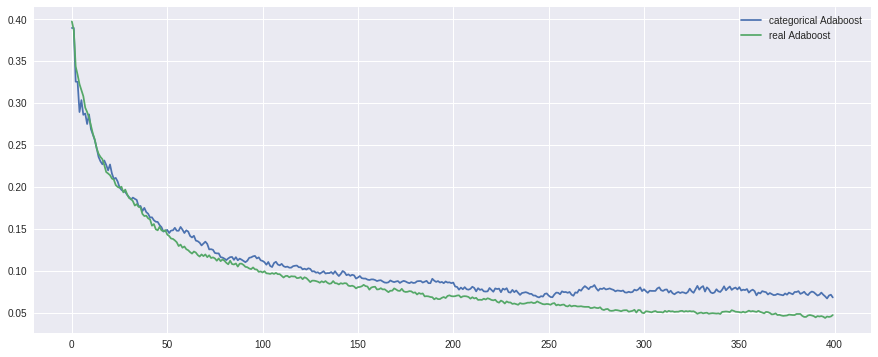

In [0]:
err_real_adaboost = [np.mean(pred != Y_s[sepidx:]) for pred in real_predictor_stump.predict_history(X_s[sepidx:])]

plt.plot(err_stump_M1, label="categorical Adaboost")
plt.plot(err_real_adaboost, label="real Adaboost")
plt.legend()
plt.show()

The differences seem quite minimal, except maybe that the real adaboost converges a bit faster.

## Subsampling

It is possible to train each tree on only a subsample of the training data.
In addition to reducing the computational cost, it can also lead to a more performant model

In [0]:
real_predictor_stump.fit(X_s[:sepidx], Y_s[:sepidx], subsampling=.5, n_iter=400)
predictor_stump.fit(X_s[:sepidx], Y_s[:sepidx], subsampling=.5, n_iter=400)

100%|██████████| 400/400 [00:05<00:00, 71.32it/s]


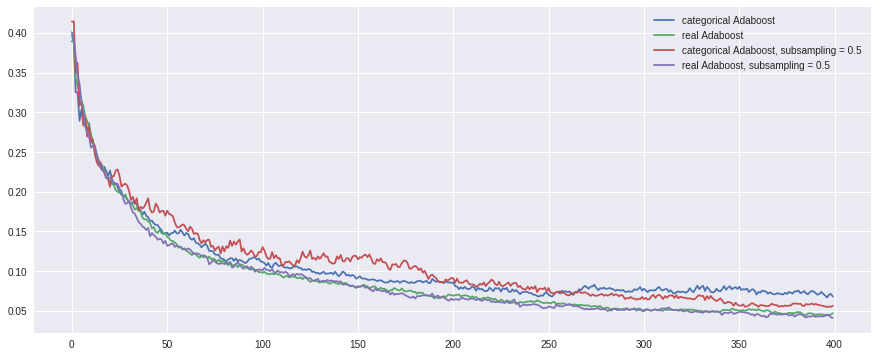

In [0]:
plt.plot(err_stump_M1, label="categorical Adaboost")
plt.plot(err_real_adaboost, label="real Adaboost")

err_real_adaboost_sub = [np.mean(pred != Y_s[sepidx:]) for pred in real_predictor_stump.predict_history(X_s[sepidx:])]
err_stump_M1_sub = [np.mean(pred != Y_s[sepidx:]) for pred in predictor_stump.predict_history(X_s[sepidx:])]


plt.plot(err_stump_M1_sub, label="categorical Adaboost, subsampling = 0.5")
plt.plot(err_real_adaboost_sub, label="real Adaboost, subsampling = 0.5")


plt.legend()
plt.show()

The results on our randomly generated dataset do not seem to indicate that subsampling seem to be better (just a bit faster), and does not work well on our categorical AdaBoost.

We can try to combine shrinkage and subsampling, as advised in Elements of Statistical Learning.

In [0]:
real_predictor_stump_shrinkage = RealAdaBoost(DecisionTreeClassifier, max_depth=1, max_leaf_nodes=2)
predictor_stump_shrinkage = AdaBoost_M1(DecisionTreeClassifier, max_depth=1, max_leaf_nodes=2)

real_predictor_stump_shrinkage.fit(X_s[:sepidx], Y_s[:sepidx], subsampling=.5, n_iter=400, shrinkage=0.25)
predictor_stump_shrinkage.fit(X_s[:sepidx], Y_s[:sepidx], subsampling=.5, n_iter=400, shrinkage=0.25)

100%|██████████| 400/400 [00:05<00:00, 72.80it/s]


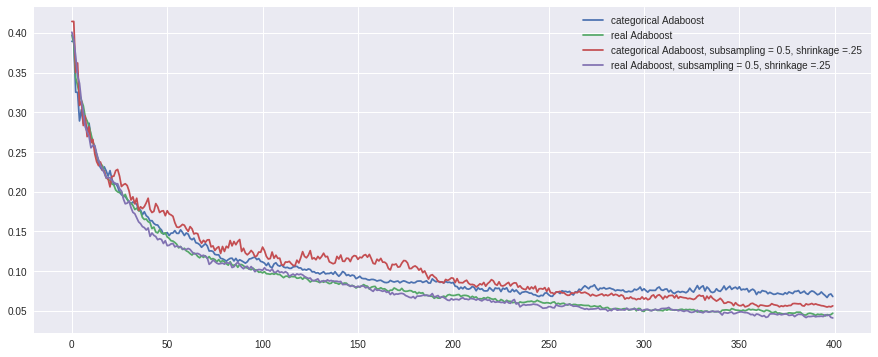

In [0]:
plt.plot(err_stump_M1, label="categorical Adaboost")
plt.plot(err_real_adaboost, label="real Adaboost")

err_real_adaboost_sub_shrink = [np.mean(pred != Y_s[sepidx:]) for pred in real_predictor_stump.predict_history(X_s[sepidx:])]
err_stump_M1_sub_shrink = [np.mean(pred != Y_s[sepidx:]) for pred in predictor_stump.predict_history(X_s[sepidx:])]


plt.plot(err_stump_M1_sub_shrink, label="categorical Adaboost, subsampling = 0.5, shrinkage =.25")
plt.plot(err_real_adaboost_sub_shrink, label="real Adaboost, subsampling = 0.5, shrinkage =.25")


plt.legend()
plt.show()

Once more, this modified version does not really outperform the standard one. 

However,  datasets in the real world are generally not as smoothly distributed as our generated dataset.

## Working on a real dataset

Rather than randomly generated data, we will now work on real-life datasets, where the tweaks we presented can actually be demonstrated to be useful.

We choose to work on the [Adult data set](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data), which determines whether or not a person makes over 50k$ a year.

It has both continous (age,  hours worked per week, number of years of education) and categorical (marital status,  occupation, relationship...)

One of the advantages of boosting algorithms (which comes from the fact they use trees) is that any type of data can be used with minimal cleaning.

In [0]:
# Download the dataset
from urllib.request import urlretrieve
adult_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

urlretrieve(adult_url, "adult.csv")

('adult.csv', <http.client.HTTPMessage at 0x7fd4d505f358>)

In [0]:
import pandas

df = pandas.read_csv("adult.csv", names=['age', "workclass", "fnlwgt", "education", 
                                         "education_num", "marital_status", "occupation", 
                                         "relationship", "race", "sex", "capital_gain", 
                                         "capital_loss", "hours_week", "native_country", "income" ])

df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [0]:
# Encode the categorical variables

cat_var = ["workclass", "education", "marital_status", "occupation", 
           "relationship", "race", "sex", "native_country"]

for var in cat_var :
    df[var] = df[var].astype("category").cat.codes

In [0]:
X_adult = df.drop('income', axis=1).as_matrix().astype(float)
Y_adult = np.ones_like(df['income'], dtype=float)
Y_adult[[df["income"] == " <=50K"]] = -1.0

# Split into training and test set
X_train, Y_train = X_adult[:25000], Y_adult[:25000]
X_test, Y_test = X_adult[25000:], Y_adult[25000:]

In [0]:
real_predictor_stump = RealAdaBoost(DecisionTreeClassifier, max_depth=1, max_features=1)
categorical_predictor_stump = AdaBoost_M1(DecisionTreeClassifier, max_depth=1, max_features=1)
real_predictor_4tree = RealAdaBoost(DecisionTreeClassifier, max_depth=4, max_features=4)


In [0]:
real_predictor_stump.fit(X_train, Y_train, n_iter=200)
categorical_predictor_stump.fit(X_train, Y_train, n_iter=200)
real_predictor_4tree.fit(X_train, Y_train, n_iter=200)

err_real = [np.mean(pred != Y_test) for pred in real_predictor_stump.predict_history(X_test)]
err_categorical = [np.mean(pred != Y_test) for pred in categorical_predictor_stump.predict_history(X_test)]
err_real_4tree = [np.mean(pred != Y_test) for pred in real_predictor_4tree.predict_history(X_test)]

100%|██████████| 200/200 [00:01<00:00, 105.53it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/tree/tree.py:864: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in add


In [0]:
# Same thing but with subsampling

real_predictor_stump.fit(X_train, Y_train, n_iter=200, subsampling=0.5)
categorical_predictor_stump.fit(X_train, Y_train, n_iter=200, subsampling=0.5)
real_predictor_4tree.fit(X_train, Y_train, n_iter=200, subsampling=0.5)


err_real_sub = [np.mean(pred != Y_test) for pred in real_predictor_stump.predict_history(X_test)]
err_categorical_sub = [np.mean(pred != Y_test) for pred in categorical_predictor_stump.predict_history(X_test)]
err_real_4tree_sub = [np.mean(pred != Y_test) for pred in real_predictor_4tree.predict_history(X_test)]

100%|██████████| 200/200 [00:01<00:00, 111.28it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/tree/tree.py:864: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in add


In [0]:
# Same thing but with shrinkage

real_predictor_stump.fit(X_train, Y_train, n_iter=200, shrinkage=0.25)
categorical_predictor_stump.fit(X_train, Y_train, n_iter=200, shrinkage=0.25)
real_predictor_4tree.fit(X_train, Y_train, n_iter=200, shrinkage=0.25)


err_real_shrink = [np.mean(pred != Y_test) for pred in real_predictor_stump.predict_history(X_test)]
err_categorical_shrink = [np.mean(pred != Y_test) for pred in categorical_predictor_stump.predict_history(X_test)]
err_real_4tree_shrink = [np.mean(pred != Y_test) for pred in real_predictor_4tree.predict_history(X_test)]

100%|██████████| 200/200 [00:01<00:00, 103.59it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/tree/tree.py:864: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in add


In [0]:
# Same thing but with subsampling and shrinkage

real_predictor_stump.fit(X_train, Y_train, n_iter=200, subsampling=0.5, shrinkage=0.25)
categorical_predictor_stump.fit(X_train, Y_train, n_iter=200, subsampling=0.5, shrinkage=0.25)
real_predictor_4tree.fit(X_train, Y_train, n_iter=200, subsampling=0.5, shrinkage=0.25)


err_real_sub_shrink = [np.mean(pred != Y_test) for pred in real_predictor_stump.predict_history(X_test)]
err_categorical_sub_shrink = [np.mean(pred != Y_test) for pred in categorical_predictor_stump.predict_history(X_test)]
err_real_4tree_sub_shrink = [np.mean(pred != Y_test) for pred in real_predictor_4tree.predict_history(X_test)]

100%|██████████| 200/200 [00:01<00:00, 106.75it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/tree/tree.py:864: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in add


As we can see here subsampling is not always faster than no subsampling as the overhead of drawing a random subsample each time can be more costly than creating a very simple decision tree on the whole sample;

We first compare the output for the categorical or discrete Adaboost

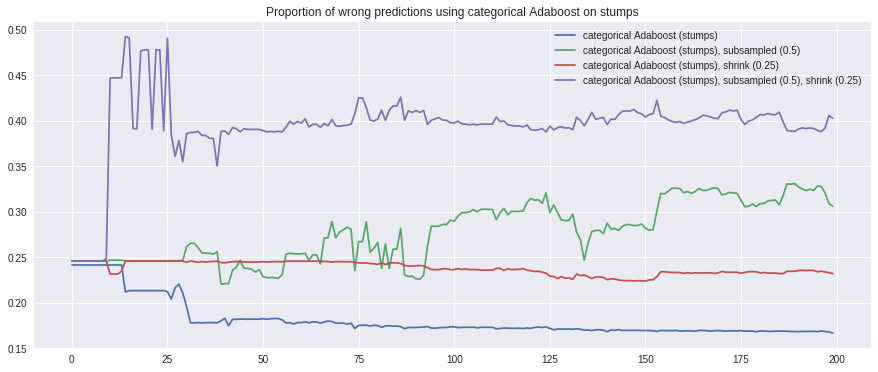

In [0]:
plt.plot(err_categorical, label="categorical Adaboost (stumps)")
plt.plot(err_categorical_sub, label="categorical Adaboost (stumps), subsampled (0.5)")
plt.plot(err_categorical_shrink, label="categorical Adaboost (stumps), shrink (0.25)")
plt.plot(err_categorical_sub_shrink, label="categorical Adaboost (stumps), subsampled (0.5), shrink (0.25)")
plt.title("Proportion of wrong predictions using categorical Adaboost on stumps")
plt.legend()
plt.show()

Then for the real Adaboost using stumps

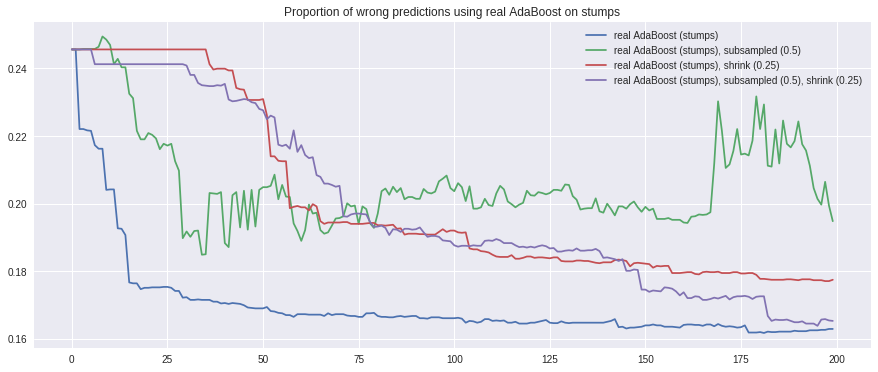

In [0]:
plt.plot(err_real, label="real AdaBoost (stumps)")
plt.plot(err_real_sub, label="real AdaBoost (stumps), subsampled (0.5)")
plt.plot(err_real_shrink, label="real AdaBoost (stumps), shrink (0.25)")
plt.plot(err_real_sub_shrink, label="real AdaBoost (stumps), subsampled (0.5), shrink (0.25)")
plt.title("Proportion of wrong predictions using real AdaBoost on stumps")
plt.legend()
plt.show()

Finally, the real Adaboost using trees with depth 4

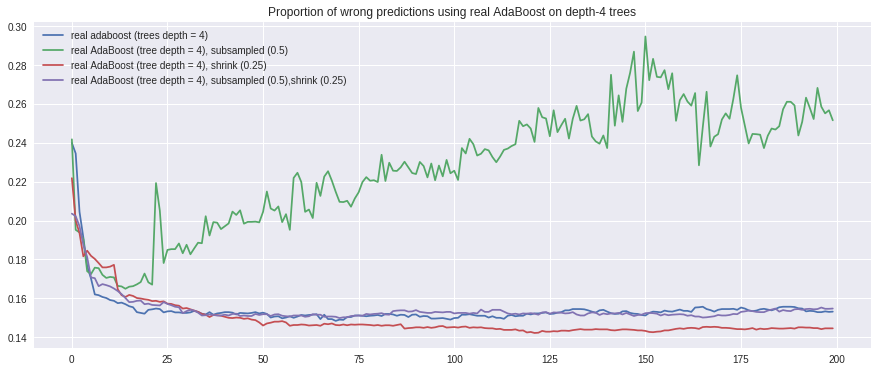

In [0]:
plt.plot(err_real_4tree, label="real adaboost (trees depth = 4)")
plt.plot(err_real_4tree_sub, label="real AdaBoost (tree depth = 4), subsampled (0.5)")
plt.plot(err_real_4tree_shrink, label="real AdaBoost (tree depth = 4), shrink (0.25)")
plt.plot(err_real_4tree_sub_shrink, label="real AdaBoost (tree depth = 4), subsampled (0.5),shrink (0.25)")
plt.title("Proportion of wrong predictions using real AdaBoost on depth-4 trees")
plt.legend()
plt.show()

We end up comparing the best performing models for each algorithm

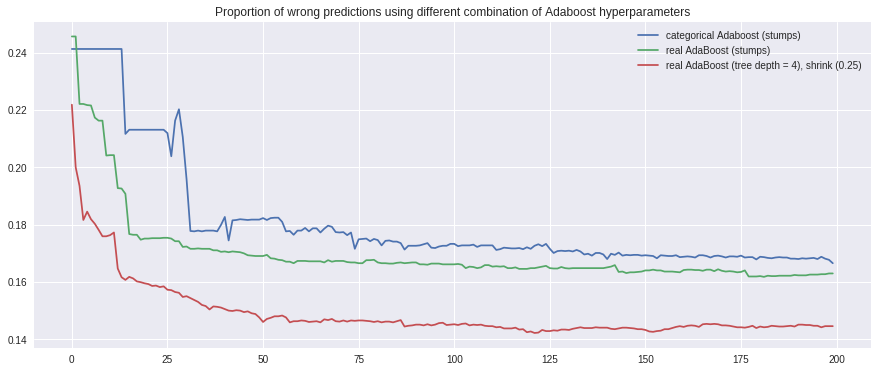

In [0]:
plt.plot(err_categorical, label="categorical Adaboost (stumps)")
plt.plot(err_real, label="real AdaBoost (stumps)")
plt.plot(err_real_4tree_shrink, label="real AdaBoost (tree depth = 4), shrink (0.25)")
plt.title("Proportion of wrong predictions using different combination of Adaboost hyperparameters")
plt.legend()
plt.show()

On a real dataset, using the real log-probabilities of each predictors rather than the prediction seems to lead to faster convergence and better precision. It is probably because the probabilities convey more information about wheter or not the predictor is "certain" of its prediction.

Subsampling seem however not to help much.

### Comparing to Gradient Boosting

We can compare our algorithm to [gradient boosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). The principle of using weak learners is the same, but instead of simply adding more weight on the subsample the previous learner did not classify well, it tries to minimize the loss function numerically by choosing the steepest descent.
We choose the default loss 'deviance'. Otherwise, for loss ‘exponential’, gradient boosting recovers the AdaBoost algorithm.

All the tweaks we have implemented in our AdaBoost algorithm can also be found in the GradientBoosting algorithm.

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

In [0]:
GB_simple = GradientBoostingClassifier(learning_rate=1, n_estimators=200,
                                       max_depth=1, max_leaf_nodes=2)

GB_4deep = GradientBoostingClassifier(learning_rate=0.5, n_estimators=200,
                                       max_depth=4, max_leaf_nodes=64)

GB_shrinkage = GradientBoostingClassifier(learning_rate=0.5, n_estimators=200,
                                       max_depth=1, max_leaf_nodes=2)

GB_subsample = GradientBoostingClassifier(learning_rate=1, n_estimators=200,
                                       max_depth=1, max_leaf_nodes=2,
                                       subsample=0.5)

GB_subsample_shrinkage = GradientBoostingClassifier(learning_rate=1, n_estimators=200,
                                                    max_depth=1, max_leaf_nodes=2,
                                                    subsample=0.5)

In [0]:
for model in [GB_simple, GB_4deep, GB_shrinkage, GB_subsample, GB_subsample_shrinkage]:
    model.fit(X_train, Y_train)

In [0]:
# Tuned predictor with all the best parameters
GB_tuned = GradientBoostingClassifier(n_estimators=200)

GB_tuned.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

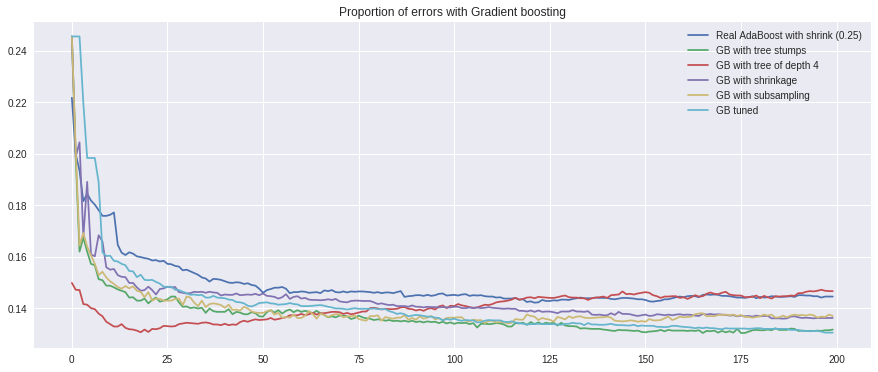

In [0]:
plt.plot(err_real_4tree_shrink, label="Real AdaBoost with shrink (0.25)")

plt.plot([np.mean(Y_test !=pred)for pred in GB_simple.staged_predict(X_test)],
            label="GB with tree stumps")

plt.plot([np.mean(Y_test !=pred)for pred in GB_4deep.staged_predict(X_test)],
            label="GB with tree of depth 4")

plt.plot([np.mean(Y_test !=pred)for pred in GB_shrinkage.staged_predict(X_test)],
            label="GB with shrinkage")

plt.plot([np.mean(Y_test !=pred)for pred in GB_subsample_shrinkage.staged_predict(X_test)],
            label="GB with subsampling")

plt.plot([np.mean(Y_test !=pred)for pred in GB_tuned.staged_predict(X_test)],
            label="GB tuned")



plt.title("Proportion of errors with Gradient boosting")
plt.legend()

plt.show()

